In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql import types as T

import json
import numpy as np

#Imports to enable visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
def rename_columns(df, list_of_tuples):
    for (old_col, new_col) in list_of_tuples:
        df = df.withColumnRenamed(old_col, new_col)
    return df

def read_hdfs_folder(sqlContext, folderpath):
    data_frame = sqlContext.read.format("com.databricks.spark.csv")\
        .option("header", "true")\
        .option("inferSchema", "true") \
        .option("nullValue", "-")\
        .load(folderpath)
        
    data_frame = rename_columns(
        data_frame,
        [
            ("cardNum18", "cardNum"),
            ("cardNum19", "userGender"),
        ]
    )
    
    date = "-".join(folderpath.split("/")[-2].split("_")[:3])

    data_frame = data_frame.withColumn("date", F.lit(date))
    data_frame = data_frame.withColumn("date", F.date_sub(F.col("date"),1))

    return data_frame

def read_buste_data_v3(sqlContext, filepath):
    data_frame = sqlContext.read.csv(filepath, header=True,
                                     inferSchema=True,nullValue="-")
    
    date = "-".join(filepath.split("/")[-2].split("_")[:3])

    data_frame = data_frame.withColumn("date", F.lit(date))
    data_frame = data_frame.withColumn("date", F.unix_timestamp(F.date_sub(F.col("date"),1),'yyyy-MM-dd'))
    
    return data_frame

def printdf(df,l=10):
    return df.limit(l).toPandas()

### Read BUSTE result Data

In [3]:
sc = SparkContext.getOrCreate()
sqlContext = pyspark.SQLContext(sc)

In [4]:
exp_data_folder_path = '/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-data/buste-v3a/'

In [5]:
buste_data = read_hdfs_folder(sqlContext, exp_data_folder_path + '/bulma-output/2017_05_11_veiculos.csv/')

In [6]:
#printdf(buste_data)

In [7]:
buste_data.printSchema()

root
 |-- route: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- cardNum: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: date (nullable = true)



In [8]:
total_records = buste_data.count()
print total_records

637707


In [9]:
total_passengers = buste_data.select('cardNum').distinct().count()
print total_passengers

107689


### Cleaning Buste Data

In [10]:
clean_buste_data = buste_data.na.drop(subset=["date","route","busCode","tripNum","stopPointId","timestamp","shapeLon","shapeLat"])

In [11]:
total_filtered_boardings = clean_buste_data.count()
print total_filtered_boardings, "(", 100*(total_filtered_boardings/float(total_records)), "%)"
#printdf(clean_buste_data)

616733 ( 96.7110287326 %)


### Preparing Boarding Data for Analysis

In [12]:
filtered_boardings = clean_buste_data.na.drop(subset=['cardNum','cardTimestamp']) \
                            .dropDuplicates(['cardNum','date','cardTimestamp'])

In [13]:
non_duplicated_boardings = filtered_boardings.count()
print non_duplicated_boardings, "(", 100*(non_duplicated_boardings/float(total_records)), "%)"
#printdf(filtered_boardings)

140031 ( 21.9585169992 %)


### Removing single-trip users records

In [14]:
boarding_count = filtered_boardings.groupby('cardNum').count()

In [15]:
#Filtering only users with more than one ride per day
multiple_boardings = boarding_count.filter(F.col('count') > 1)

In [16]:
total_passengers = filtered_boardings.select('cardNum').distinct().count()
print "Total #Passengers:", total_passengers

Total #Passengers: 107688


In [17]:
passengers_mult_boardings = multiple_boardings.count()
prop_mult_boardings = 100*(passengers_mult_boardings)/total_passengers
print "Passengers with Multiple Boardings:", passengers_mult_boardings, "(", prop_mult_boardings, "%)" 
#multiple_boardings.show()

Passengers with Multiple Boardings: 26687 ( 24 %)


In [18]:
multiple_boardings = multiple_boardings.select(F.col("cardNum").alias("cardNum1"),
                                                 F.col("count").alias("count1"))

In [19]:
clean_boardings = filtered_boardings.join(multiple_boardings, filtered_boardings.cardNum == multiple_boardings.cardNum1, 'leftsemi')

In [20]:
clean_boardings.count()

59030

In [21]:
#printdf(clean_boardings)

In [22]:
clean_boardings.write.csv(path=exp_data_folder_path+'/clean_boardings',header=True, mode='overwrite')

### Generating User Trips Matrix

In [23]:
boarding_data = clean_boardings.withColumn('boarding_id',F.monotonically_increasing_id())
#printdf(boarding_data)

In [24]:
user_boarding_w = Window.partitionBy(boarding_data.cardNum, boarding_data.date).orderBy(boarding_data.cardTimestamp)
od_matrix_ids = boarding_data.select(F.col('cardNum'),
                     F.col('boarding_id'), 
                     F.lead('boarding_id',default=-1).over(user_boarding_w).alias('next_boarding_id'),
                     F.first('boarding_id',True).over(user_boarding_w).alias('first_boarding')) \
                    .withColumn('next_boarding_id', 
                         F.when(F.col('next_boarding_id') == -1,F.col('first_boarding')). \
                                         otherwise(F.col('next_boarding_id'))).drop('first_boarding')

#printdf(od_matrix_ids)

In [25]:
boarding_data.printSchema()

root
 |-- route: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- cardNum: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: date (nullable = true)
 |-- boarding_id: long (nullable = false)



In [26]:
origin_matrix = boarding_data.select(F.col("route").alias("o_route"),
                                    F.col("busCode").alias("o_bus_code"),
                                    F.col("date").alias("o_date"),
                                    F.col("tripNum").alias("o_tripNum"),
                                    F.col("cardTimestamp").alias("o_timestamp"),
                                    F.col("shapeId").alias("o_shape_id"),
                                    F.col("shapeSequence").alias("o_shape_seq"),
                                    F.col("shapeLat").alias("o_shape_lat"),
                                    F.col("shapeLon").alias("o_shape_lon"),
                                    F.col("stopPointId").alias("o_stop_id"),
                                    F.col("boarding_id").alias("o_boarding_id"))

In [27]:
next_origin_matrix = boarding_data.select(F.col("route").alias("next_o_route"),
                                    F.col("busCode").alias("next_o_bus_code"),
                                    F.col("date").alias("next_o_date"),
                                    F.col("tripNum").alias("next_o_tripNum"),
                                    F.col("cardTimestamp").alias("next_o_timestamp"),
                                    F.col("shapeId").alias("next_o_shape_id"),
                                    F.col("shapeSequence").alias("next_o_shape_seq"),
                                    F.col("shapeLat").alias("next_o_shape_lat"),
                                    F.col("shapeLon").alias("next_o_shape_lon"),
                                    F.col("stopPointId").alias("next_o_stop_id"),
                                    F.col("boarding_id").alias("next_o_boarding_id"))

In [28]:
#printdf(origin_matrix)

In [29]:
#printdf(next_origin_matrix)

In [30]:
user_trips = origin_matrix.join(od_matrix_ids, 
                                        origin_matrix.o_boarding_id == od_matrix_ids.boarding_id, 'inner') \
                                    .join(next_origin_matrix, od_matrix_ids.next_boarding_id == next_origin_matrix.next_o_boarding_id, 'inner') \
                                    .drop('boarding_id') \
                                    .drop('next_boarding_id')

In [31]:
user_trips.printSchema()

root
 |-- o_route: string (nullable = true)
 |-- o_bus_code: string (nullable = true)
 |-- o_date: date (nullable = true)
 |-- o_tripNum: integer (nullable = true)
 |-- o_timestamp: string (nullable = true)
 |-- o_shape_id: integer (nullable = true)
 |-- o_shape_seq: integer (nullable = true)
 |-- o_shape_lat: double (nullable = true)
 |-- o_shape_lon: double (nullable = true)
 |-- o_stop_id: integer (nullable = true)
 |-- o_boarding_id: long (nullable = false)
 |-- cardNum: integer (nullable = true)
 |-- next_o_route: string (nullable = true)
 |-- next_o_bus_code: string (nullable = true)
 |-- next_o_date: date (nullable = true)
 |-- next_o_tripNum: integer (nullable = true)
 |-- next_o_timestamp: string (nullable = true)
 |-- next_o_shape_id: integer (nullable = true)
 |-- next_o_shape_seq: integer (nullable = true)
 |-- next_o_shape_lat: double (nullable = true)
 |-- next_o_shape_lon: double (nullable = true)
 |-- next_o_stop_id: integer (nullable = true)
 |-- next_o_boarding_id: lo

In [32]:
#printdf(user_trips)

In [34]:
#printdf(user_trips.select(['cardNum','o_route','o_bus_code','o_timestamp','o_stop_id','next_o_route','next_o_bus_code','next_o_timestamp','next_o_stop_id']).
#        orderBy(['cardNum','o_timestamp',]), l=30)

In [35]:
user_trips.count()

59030

In [36]:
user_trips = user_trips.withColumn('o_unixtimestamp',F.unix_timestamp(F.col('o_timestamp'), 'HH:mm:ss')) \
                                        .withColumn('next_o_unixtimestamp',F.unix_timestamp(F.col('next_o_timestamp'), 'HH:mm:ss'))
                                        

In [37]:
#printdf(user_trips)

In [38]:
user_trips = user_trips.withColumn('leg_duration',
                                                   F.when(F.col('next_o_unixtimestamp') > F.col('o_unixtimestamp'),
                                                       ((F.col('next_o_unixtimestamp') - F.col('o_unixtimestamp'))/60.0)). \
                                                   otherwise(-1))                                        

In [39]:
#printdf(user_trips.select(['cardNum','o_timestamp','o_unixtimestamp','next_o_timestamp','next_o_unixtimestamp','leg_duration']),l=30)

In [40]:
#printdf(user_trips.filter('leg_duration < -1 or leg_duration > 15').describe(['leg_duration']))

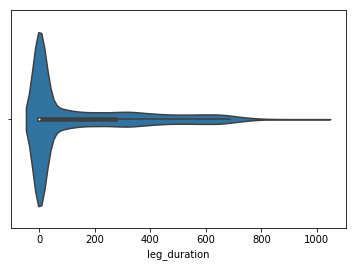

In [41]:
sns.violinplot(x=user_trips.toPandas()["leg_duration"])

In [42]:
user_trips.filter('leg_duration > 0').approxQuantile("leg_duration", [0.5], 0)

[281.0833333333333]

In [43]:
user_trips.write.csv(exp_data_folder_path + '/user_trips', header=True, mode='overwrite')

### Infer Destination Stops

In [44]:
user_trips_data = user_trips \
                .withColumn('o_date',F.from_unixtime(F.unix_timestamp(F.col('o_date'),'yyyy-MM-dd'), 'yyyy-MM-dd')) \
                .withColumn('next_o_date',F.from_unixtime(F.unix_timestamp(F.col('next_o_date'),'yyyy-MM-dd'), 'yyyy-MM-dd')) \
                .orderBy(['cardNum','o_date','o_timestamp'])

In [45]:
#printdf(user_trips_data)

### Using BUSTE Data as a basis to infer trips destination locations

In [46]:
bus_trip_data = clean_buste_data.orderBy(['route','busCode','tripNum','timestamp']) \
                            .dropDuplicates(['route','busCode','tripNum','stopPointId']) \
                            .drop('cardNum') \
                            .withColumn('id',F.monotonically_increasing_id()) \
                            .withColumn('route', F.col('route').cast(T.IntegerType())) \
                            .withColumnRenamed('','cardNum')

In [47]:
user_trips_data.printSchema()

root
 |-- o_route: string (nullable = true)
 |-- o_bus_code: string (nullable = true)
 |-- o_date: string (nullable = true)
 |-- o_tripNum: integer (nullable = true)
 |-- o_timestamp: string (nullable = true)
 |-- o_shape_id: integer (nullable = true)
 |-- o_shape_seq: integer (nullable = true)
 |-- o_shape_lat: double (nullable = true)
 |-- o_shape_lon: double (nullable = true)
 |-- o_stop_id: integer (nullable = true)
 |-- o_boarding_id: long (nullable = false)
 |-- cardNum: integer (nullable = true)
 |-- next_o_route: string (nullable = true)
 |-- next_o_bus_code: string (nullable = true)
 |-- next_o_date: string (nullable = true)
 |-- next_o_tripNum: integer (nullable = true)
 |-- next_o_timestamp: string (nullable = true)
 |-- next_o_shape_id: integer (nullable = true)
 |-- next_o_shape_seq: integer (nullable = true)
 |-- next_o_shape_lat: double (nullable = true)
 |-- next_o_shape_lon: double (nullable = true)
 |-- next_o_stop_id: integer (nullable = true)
 |-- next_o_boarding_id

In [48]:
bus_trip_data.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: date (nullable = true)
 |-- id: long (nullable = false)



In [49]:
cond = [bus_trip_data.route == user_trips_data.o_route, 
        bus_trip_data.busCode == user_trips_data.o_bus_code, 
        bus_trip_data.date == user_trips_data.o_date,
        bus_trip_data.tripNum == user_trips_data.o_tripNum]
od_trips = bus_trip_data.join(user_trips_data, cond, 'left_outer')

In [50]:
#printdf(od_trips.orderBy(['route','busCode','tripNum','timestamp']))

In [51]:
print od_trips.count()

3877508


In [52]:
trips_with_boardings = od_trips
#printdf(trips_with_boardings,l=100)

In [53]:
def dist(lat_x, long_x, lat_y, long_y):
    return F.acos(
        F.sin(F.toRadians(lat_x)) * F.sin(F.toRadians(lat_y)) + 
        F.cos(F.toRadians(lat_x)) * F.cos(F.toRadians(lat_y)) * 
            F.cos(F.toRadians(long_x) - F.toRadians(long_y))
    ) * F.lit(6371.0)

In [54]:
trips_with_boardings = trips_with_boardings.withColumn('dist',dist(F.col('shapeLat'),F.col('shapeLon'),F.col('next_o_shape_lat'),F.col('next_o_shape_lon')))

In [55]:
#printdf(trips_with_boardings,l=100)

In [56]:
w = Window().partitionBy(['cardNum','date','route','busCode','tripNum']).orderBy('dist')

od_matrix = trips_with_boardings.filter('timestamp > o_timestamp') \
                    .withColumn('rn', F.row_number().over(w)) \
                    .where(F.col('rn') == 1)

In [57]:
# printdf(od_matrix.select(['cardNum','route','tripNum','o_stop_id','o_timestamp','stopPointId','timestamp','dist']) \
#                     .orderBy(['cardNum','o_timestamp']), l=100)

In [58]:
# printdf(od_matrix.select(['cardNum','o_stop_id','o_timestamp','stopPointId','timestamp','shapeLat','shapeLon','next_o_shape_lat','next_o_shape_lon','dist']) \
#                     .orderBy(['cardNum','o_timestamp']), l=100)

In [59]:
printdf(od_matrix.describe('dist'))

,summary,dist
0,count,54230
1,mean,6.71390882852522
2,stddev,4.4788440291974965
3,min,0.0
4,max,30.172753958356612


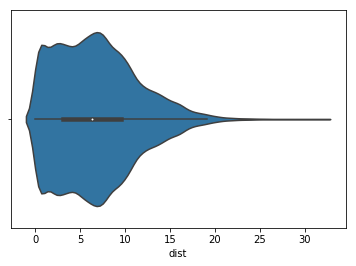

In [60]:
sns.violinplot(x=od_matrix.toPandas()["dist"])

In [61]:
inference_ok = 100*(od_matrix.filter('dist <= 1.0').count()/float(od_matrix.count()))
print "Percentage of trips with destionation satisfying threshold: ", inference_ok, "%"

Percentage of trips with destionation satisfying threshold:  9.47814862622 %


In [62]:
print od_matrix.count()

54230


In [63]:
filtered_od_matrix = od_matrix.filter('dist <= 1.0')

In [83]:
printdf(filtered_od_matrix.select(['cardNum','o_stop_id','o_timestamp','stopPointId','timestamp','shapeLat','shapeLon','next_o_shape_lat','next_o_shape_lon','dist']) \
                    .orderBy(['cardNum','o_timestamp']), l=100)

,cardNum,o_stop_id,o_timestamp,stopPointId,timestamp,shapeLat,shapeLon,next_o_shape_lat,next_o_shape_lon,dist
0,321916,26152,18:30:42,26583,18:34:45,-25.439813,-49.269599,-25.435150,-49.273297,0.637693
1,328918,39855,16:17:06,32042,16:27:34,-25.536414,-49.301342,-25.537553,-49.294947,0.654012
2,331911,26345,12:56:49,26720,13:03:29,-25.429159,-49.276425,-25.432850,-49.270418,0.729595
3,334290,34106,08:09:14,35561,08:24:01,-25.475999,-49.336730,-25.478637,-49.340064,0.445023
4,334355,26149,08:13:56,32104,08:25:30,-25.446778,-49.281412,-25.449833,-49.279457,0.392340
5,337143,37562,09:31:18,29420,09:38:56,-25.430950,-49.276733,-25.435150,-49.273297,0.580618
6,342587,35725,18:14:58,32655,22:13:51,-25.494650,-49.324911,-25.491148,-49.328388,0.522865
7,343127,35261,07:00:56,26140,07:34:07,-25.434736,-49.272225,-25.435352,-49.273778,0.170326
8,343127,30557,07:01:30,30539,08:00:58,-25.485251,-49.279978,-25.483014,-49.270460,0.987231
9,345503,37412,07:17:38,37146,07:26:31,-25.544267,-49.294199,-25.543646,-49.290868,0.341229


In [85]:
print filtered_od_matrix.count()

5140


In [84]:
filtered_od_matrix.write.csv(path=exp_data_folder_path+'/od_matrix',header=True, mode='overwrite')

### Enriching BUSTE output with bus crowdedness information

In [65]:
trips_origins = filtered_od_matrix.filter(filtered_od_matrix.cardNum.isNotNull()) \
                            .select(['o_date','o_route','o_bus_code','o_tripNum','o_stop_id','o_timestamp']) \
                            .groupBy(['o_date','o_route','o_bus_code','o_tripNum','o_stop_id']) \
                            .count() \
                            .withColumnRenamed('count','boarding_cnt') \
                            .orderBy(['o_date','o_route','o_bus_code','o_tripNum'])

In [66]:
#printdf(trips_origins, l=20)

In [67]:
trips_destinations = filtered_od_matrix.filter(filtered_od_matrix.cardNum.isNotNull()) \
                            .select(['date','route','busCode','tripNum','stopPointId','timestamp']) \
                            .groupBy(['date','route','busCode','tripNum','stopPointId']) \
                            .count() \
                            .orderBy(['date','route','busCode','tripNum'])

In [68]:
trips_destinations = rename_columns(
                        trips_destinations,
                        [('date','d_date'),
                         ('route','d_route'),
                         ('busCode','d_bus_code'),
                         ('tripNum','d_tripNum'),
                         ('stopPointId','d_stop_id'),
                         ('count','alighting_cnt')])

In [69]:
#printdf(trips_destinations, l=20)

In [70]:
origin_cond = [bus_trip_data.date == trips_origins.o_date,
               bus_trip_data.route == trips_origins.o_route, 
               bus_trip_data.busCode == trips_origins.o_bus_code, 
               bus_trip_data.tripNum == trips_origins.o_tripNum,
               bus_trip_data.stopPointId == trips_origins.o_stop_id
]

dest_cond = [bus_trip_data.date == trips_destinations.d_date,
               bus_trip_data.route == trips_destinations.d_route, 
               bus_trip_data.busCode == trips_destinations.d_bus_code, 
               bus_trip_data.tripNum == trips_destinations.d_tripNum,
               bus_trip_data.stopPointId == trips_destinations.d_stop_id
]


buste_crowdedness = bus_trip_data.join(trips_origins,origin_cond,'left_outer') \
                        .join(trips_destinations,dest_cond,'left_outer') \
                        .drop('o_date','o_route','o_bus_code','o_tripNum','o_stop_id') \
                        .drop('d_date','d_route','d_bus_code','d_tripNum','d_stop_id') \
                        .withColumn('boarding_cnt',F.when(F.col('boarding_cnt').isNull(),F.lit(0)).otherwise(F.col('boarding_cnt'))) \
                        .withColumn('alighting_cnt',F.when(F.col('alighting_cnt').isNull(),F.lit(0)).otherwise(F.col('alighting_cnt'))) \

In [71]:
#printdf(buste_crowdedness.filter(buste_crowdedness.boarding_cnt > 0))

In [72]:
trips_window = Window.partitionBy(['date','route','busCode','tripNum']).orderBy('timestamp')

buste_crowdedness = buste_crowdedness.withColumn('crowd_bal', F.col('boarding_cnt') - F.col('alighting_cnt')) \
                        .withColumn('num_pass',F.sum('crowd_bal').over(trips_window)) \
                        .drop('numPassengers','gps_timestamp','gps_timestamp_in_secs') \
                        .orderBy(['date','route','busCode','tripNum','timestamp'])                        

In [74]:
# printdf(buste_crowdedness.select(['date','route','busCode','tripNum','stopPointId','timestamp','boarding_cnt','alighting_cnt','crowd_bal','num_pass']) \
#                            .orderBy(['date','route','busCode','tripNum','timestamp'])
#        ,l=100)

### Extrapolating results to all trips based on per-route proportion

In [75]:
boarding_data_route_boarding = bus_trip_data.groupby(['route']).count() \
                                .withColumnRenamed('count','overall_boarding')
#printdf(boarding_data_route_boarding)

In [76]:
od_matrix_route_boarding = filtered_od_matrix.groupby(['route']).count() \
                            .withColumnRenamed('count','odmatrix_boarding')
#printdf(od_matrix_route_boarding)

In [77]:
od_matrix_route_prop = boarding_data_route_boarding.join(od_matrix_route_boarding, 'route','left_outer') \
                        .withColumn('extrap_factor',F.when(((F.col('odmatrix_boarding') == 0) | (F.col('odmatrix_boarding').isNull())), 0.0) \
                                    .otherwise(F.col('overall_boarding').cast('float')/F.col('odmatrix_boarding')))

In [78]:
#printdf(od_matrix_route_prop,l=30)

In [79]:
buste_crowdedness_extrapolated = buste_crowdedness.join(od_matrix_route_prop, 'route', 'left') \
                                .drop('overall_boarding','odmatrix_boarding') \
                                .withColumn('ext_num_pass', F.col('num_pass')*F.col('extrap_factor'))

In [81]:
printdf(buste_crowdedness_extrapolated.select(['date','route','busCode','tripNum','stopPointId','timestamp','boarding_cnt','alighting_cnt','crowd_bal','num_pass','extrap_factor','ext_num_pass']) \
                           .orderBy(['date','route','busCode','tripNum','timestamp']) \
                            .filter('num_pass > 0')
       ,l=100)

,date,route,busCode,tripNum,stopPointId,timestamp,boarding_cnt,alighting_cnt,crowd_bal,num_pass,extrap_factor,ext_num_pass
0,2017-05-10,1,BN997,4,35219,07:51:57,1,0,1,1,202.000000,202.000000
1,2017-05-10,1,BN997,4,29420,07:53:54,0,0,0,1,202.000000,202.000000
2,2017-05-10,1,BN997,4,29082,07:54:48,0,0,0,1,202.000000,202.000000
3,2017-05-10,1,BN997,19,31453,13:37:13,1,0,1,1,202.000000,202.000000
4,2017-05-10,1,BN997,19,31454,13:38:36,0,0,0,1,202.000000,202.000000
5,2017-05-10,1,BN997,19,30748,13:39:59,0,0,0,1,202.000000,202.000000
6,2017-05-10,1,BN997,19,30749,13:40:10,0,0,0,1,202.000000,202.000000
7,2017-05-10,1,BN997,19,35216,13:41:31,0,0,0,1,202.000000,202.000000
8,2017-05-10,1,BN997,19,26166,13:43:53,0,0,0,1,202.000000,202.000000
9,2017-05-10,1,BN997,19,35219,13:45:56,0,0,0,1,202.000000,202.000000


In [82]:
buste_crowdedness_extrapolated.write.csv(path=exp_data_folder_path+'/buste_crowdedness',header=True, mode='overwrite')